In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import ml_collections
import sys
sys.path.insert(0, '/scratch/aa11803/tauLDR')
from config.eval.cifar10 import get_config as get_eval_config
import lib.utils.bookkeeping as bookkeeping
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import lib.utils.utils as utils
import lib.models.models as models
import lib.models.model_utils as model_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils

%matplotlib inline

eval_cfg = get_eval_config()
train_cfg = bookkeeping.load_ml_collections(Path(eval_cfg.train_config_path))

for item in eval_cfg.train_config_overrides:
    utils.set_in_nested_dict(train_cfg, item[0], item[1])

S = train_cfg.data.S
device = torch.device(eval_cfg.device)

model = model_utils.create_model(train_cfg, device)

loaded_state = torch.load(Path(eval_cfg.checkpoint_path),
    map_location=device)

modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
model.load_state_dict(modified_model_state)

model.eval()

def imgtrans(x):
    x = np.transpose(x, (1,2,0))
    return x

2024-10-01 10:37:02.272081: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 10:37:02.274192: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-01 10:37:02.318812: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 10:37:03.523323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_2693417/1318475704.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the 

In [ ]:
# -------------- Sample the model ------------------
n_int = 499000
num_samples = 100
sampler = sampling_utils.get_sampler(eval_cfg)
samples, x_hist, rr_hist = sampler.sample(model, num_samples, n_int)

samples = samples.reshape(num_samples, 3, 32, 32)
# x_hist = x_hist.reshape(2**16, num_samples, 3, 32, 32)
# x0_hist = x0_hist.reshape(2**16, num_samples, 3, 32, 32)

2905it [09:31,  5.09it/s]

In [ ]:
rr_hist.shape

In [7]:
import torch
model.rate(torch.tensor([0.1]).cuda())[0]

tensor([[-127.3776,   21.8961,   21.2963,  ...,    0.0000,    0.0000,
            0.0000],
        [  21.8855, -149.2631,   21.8961,  ...,    0.0000,    0.0000,
            0.0000],
        [  21.2758,   21.8856, -170.5390,  ...,    0.0000,    0.0000,
            0.0000],
        ...,
        [   0.0000,    0.0000,    0.0000,  ..., -170.5388,   21.8855,
           21.2756],
        [   0.0000,    0.0000,    0.0000,  ...,   21.8961, -149.2630,
           21.8855],
        [   0.0000,    0.0000,    0.0000,  ...,   21.2963,   21.8961,
         -127.3776]], device='cuda:0')

In [59]:
help(model)

Help on GaussianTargetRateImageX0PredEMA in module lib.models.models object:

class GaussianTargetRateImageX0PredEMA(EMA, ImageX0PredBase, GaussianTargetRate)
 |  GaussianTargetRateImageX0PredEMA(cfg, device, rank=None)
 |  
 |  Base class for all neural network modules.
 |  
 |  Your models should also subclass this class.
 |  
 |  Modules can also contain other Modules, allowing to nest them in
 |  a tree structure. You can assign the submodules as regular attributes::
 |  
 |      import torch.nn as nn
 |      import torch.nn.functional as F
 |  
 |      class Model(nn.Module):
 |          def __init__(self):
 |              super().__init__()
 |              self.conv1 = nn.Conv2d(1, 20, 5)
 |              self.conv2 = nn.Conv2d(20, 20, 5)
 |  
 |          def forward(self, x):
 |              x = F.relu(self.conv1(x))
 |              return F.relu(self.conv2(x))
 |  
 |  Submodules assigned in this way will be registered, and will have their
 |  parameters converted too when you c

In [51]:
x_hist.shape

(16384, 5, 3, 32, 32)

In [8]:
diffs = np.array([(x_hist[i] != x_hist[i+1]).mean() for i in range(len(x_hist)-1)])

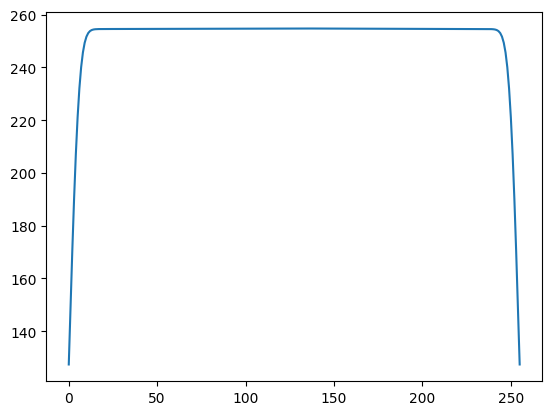

In [116]:
plt.plot(-model.rate(torch.tensor([0.1]).cuda())[0][range_, range_].cpu())

In [9]:
from tqdm import tqdm
range_ = np.arange(256)
rates_max = np.array([model.rate(torch.tensor([t]).cuda())[0][range_, range_].min().cpu().numpy()
                  for t in np.linspace(0.01, 1, int(2**10))])
rates_min = np.array([model.rate(torch.tensor([t]).cuda())[0][range_, range_].max().cpu().numpy()
                  for t in np.linspace(0.01, 1, int(2**10))])

In [ ]:
p0 = np.load('../d3pm/save_alphas/cifar10_p0.npy')
np.save('../d3pm/save_alphas/tauldr_rr_hist.npy', rr_hist)

In [ ]:
av_rates = []
range_ = np.arange(256)
ts = np.linspace(0.01, 1, int(2**11))
for t in ts:
    pt = p0 @ model.transition(torch.tensor([t]).cuda().float())[0].cpu().numpy()
    rates = model.rate(torch.tensor([t]).cuda().float())[0].cpu().numpy()
    av_rate = rates[range_, range_] @ pt
    av_rates.append(av_rate)

In [35]:
(-rr_hist.mean(-1)[::-1]-(-np.array(av_rates))).mean()

-1.4967325627803816

In [26]:
np.log(rt / rp)

array([ 4.56745421e-03,  6.65171852e-03,  6.33808694e-03, ...,
        1.62942996e-03,  2.75273671e-03, -5.92627312e-05])

In [25]:
rt

array([  166.33359,   166.71445,   167.0959 , ..., 15744.837  ,
       15779.943  , 15815.127  ], dtype=float32)

In [ ]:
plt.semilogy(ts, -np.array(av_rates))
plt.semilogy(ts, -rr_hist.mean(-1)[::-1])

plt.figure()
# plt.semilogy()
rp = -rr_hist.mean(-1)[::-1]
rt = (-np.array(av_rates))
kls = rp - rt + rt * np.log(rt / rp)
plt.plot(ts, kls)

plt.figure(figsize=[7, 3])
plt.plot(ts, 0*ts, color='black')
plt.plot(ts[:-1], (rp - rt)[:-1])
plt.ylabel("$\Delta$ Transition rate", fontsize=20)
plt.xlabel("t", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-21, 12)
plt.xlim(0, 1)

# plt.semilogy(diffs * 2**10)
# plt.semilogy(-rates_min[::-1])
# plt.semilogy(-rates_max[::-1])

In [ ]:
def moving_average(x, window=9):
    return torch.nn.functional.avg_pool1d(x.unsqueeze(0), window, stride=1, padding=window//2).squeeze(0)
plt.figure(figsize=[7, 2])
plt.plot(ts, 0*ts, color='black', ls='--')
plt.plot(ts[:-1], moving_average(torch.tensor(rp - rt))[:-1],
         lw=3, color='blue')
plt.ylabel("$\Delta$ Trans. rate", fontsize=20)
plt.xlabel("t", fontsize=20)
plt.xticks([0, 1], [0, 1],fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-5, 10)
plt.xlim(0, 1)
# plt.tight_layout()

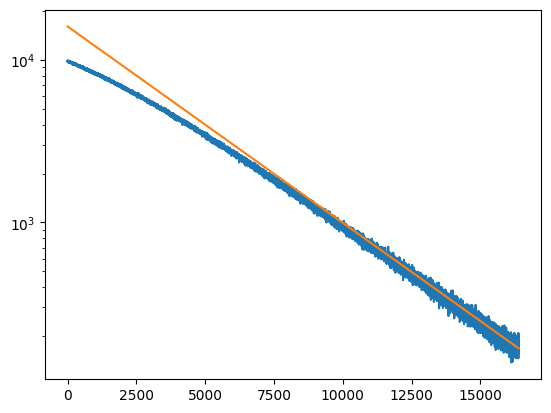

In [96]:
plt.semilogy(diffs * 2**16)
plt.semilogy(-rates[::-1])

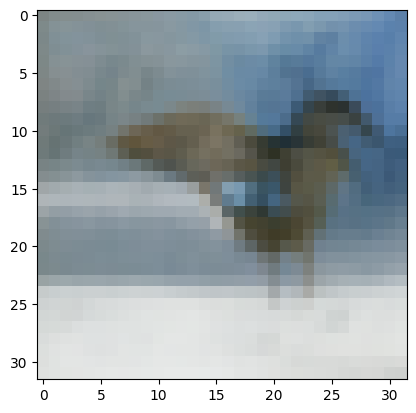

In [26]:
# ------------- Display the sample ------------
idx = 0
plt.imshow(imgtrans(samples[idx, ...]))
plt.show()

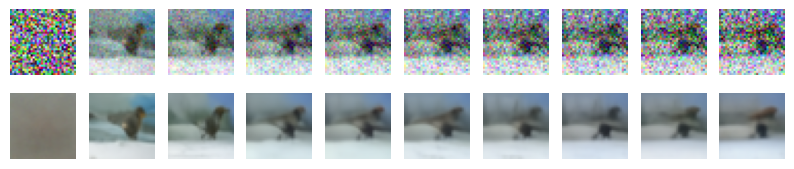

In [27]:
# --------------- Display the progression during sampling -----------
# first row is the progression of the sample itself
# second row is the progression of the x0 predictions
idx = 0
l=20
fig, ax = plt.subplots(2, 10)
for i in range(10):
    ax[0, i].imshow(imgtrans(x_hist[-i*l, idx, ...]))
    ax[0, i].axis('off')
    ax[1, i].imshow(imgtrans(x0_hist[-i*l, idx, ...]))
    ax[1, i].axis('off')
plt.gcf().set_size_inches(10, 2)
plt.show()